In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from filters import *
from measurement import *
from simulation import *

In [2]:
# global parameters
IX, IY, IVX, IVY, IAX, IAY = 0, 1, 2, 3, 4, 5 # indexes in state
T = 0.05  # time between cycles
dim_state = 6 # dimension of state
dim_meas = 4 # dimension of measurements
std_x, std_y = 0.5, 0.5
std_vx, std_vy = 0.5, 0.5

# defining scenario
n_frames = int(10/T)
frame_vec = np.arange(n_frames)
x_init = np.array([0, 0, 5, 2, 0, 0])
ax_periods = [2/T, 4/T, -3]
ay_periods = [0, 0, 0]

# simulating scenario, use LKF_CA F matrix for transition
kf_sim = LKF_CA(T)
sim_state = simulate_motion(kf_sim, dim_state, n_frames, x_init, ax_periods, ay_periods)

TypeError: LKF_CA.__init__() missing 1 required positional argument: 'meas_fn'

In [17]:
SEED = 0
np.random.seed(SEED)

# KF 
filters = [
    {
        'filter': IMM_CV_CA,
        'params': {'t_mat': np.array([[0.9, 0.1], [0.1, 0.9]])},
        'label': "IMM_CV_CA"
    },
    {
        'filter': LKF_CA,
        'params': {},
        'label': "CA"
    },
    {
        'filter': LKF_CV,
        'params': {},
        'label': "CV"
    },
]
n_iter = 30
n_filters = len(filters)
R = np.diag([std_x, std_y, std_vx, std_vy])**2

kf_errors = np.zeros((n_filters, n_iter, dim_meas, n_frames))
kf_lkl = np.zeros((n_filters, n_iter, n_frames))
for j, filt in enumerate(filters):
    print(filt['label'])
    KF = filt['filter'](T, **filt['params'])

    meas_errors = np.zeros((n_iter, dim_meas, n_frames))
    for k in range(n_iter):
        # generating measurements by corrupting with gaussian noise
        meas = np.zeros((dim_meas, n_frames))
        for i, std_ in enumerate([std_x, std_y, std_vx, std_vy]):
            meas[i, :] = sim_state[i, :] + std_*np.random.randn(n_frames)

        # applying KF
        kf_state = np.zeros_like(sim_state)
        for i in range(n_frames):
            z = meas[:, i]
            if i==0:
                # initializing KF
                KF.initialize_filter(z)
            else:
                KF.predict()
                KF.update(z, R)
                if (KF.__class__.__name__ == 'LKF_CV'):
                    kf_state[:dim_meas, i] = KF.x
                else:
                    kf_state[:, i] = KF.x
                kf_lkl[j, k, i] = KF.likelihood

        # evaluating KF
        kf_errors[j, k, :, :] = kf_state[0:dim_meas, :] - sim_state[0:dim_meas, :]
        meas_errors[k, :, :] = meas - sim_state[0:dim_meas, :]

IMM_CV_CA
CA
CV


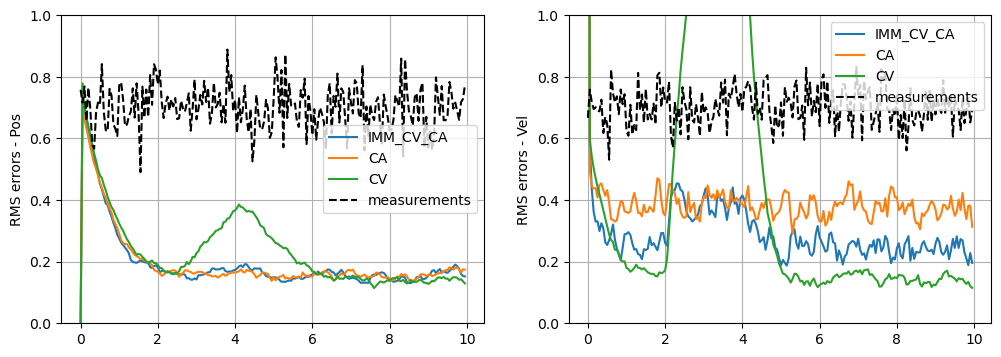

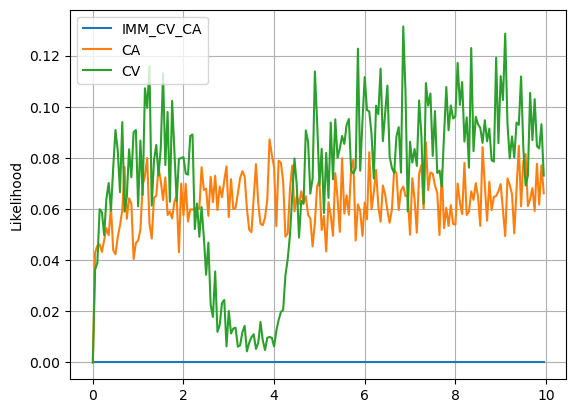

In [21]:
# evaluating KF
time_vec = np.arange(n_frames) * T
kf_sqerr = kf_errors**2
m_sqerr = meas_errors**2
kf_rms_pos_err = np.sqrt(np.mean(kf_sqerr[:, :, IX, :] + kf_sqerr[:, :, IY, :], axis=1))
kf_rms_vel_err = np.sqrt(np.mean(kf_sqerr[:, :, IVX, :] + kf_sqerr[:, :, IVY, :], axis=1))
meas_rms_pos_err = np.sqrt(np.mean(m_sqerr[:, IX, :] + m_sqerr[:, IY, :], axis=0))
meas_rms_vel_err = np.sqrt(np.mean(m_sqerr[:, IVX, :] + m_sqerr[:, IVY, :], axis=0))
kf_mean_lkl = np.mean(kf_lkl, axis=1)

labels = ['RMS errors - Pos', 'RMS errors - Vel']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
for i, rms in enumerate([(kf_rms_pos_err, meas_rms_pos_err), (kf_rms_vel_err, meas_rms_vel_err)]):
    ax = axes[i]
    for j, filt in enumerate(filters):
        ax.plot(time_vec, rms[0][j, :], '-', label=filt['label'])
    ax.plot(time_vec, rms[1], 'k--', label='measurements')
    ax.set_ylabel(labels[i])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid()

fig, ax = plt.subplots()
for j, filt in enumerate(filters):
    ax.plot(time_vec, kf_mean_lkl[j, :], label=filt['label'])
ax.grid()
ax.set_ylabel('Likelihood')
ax.legend()

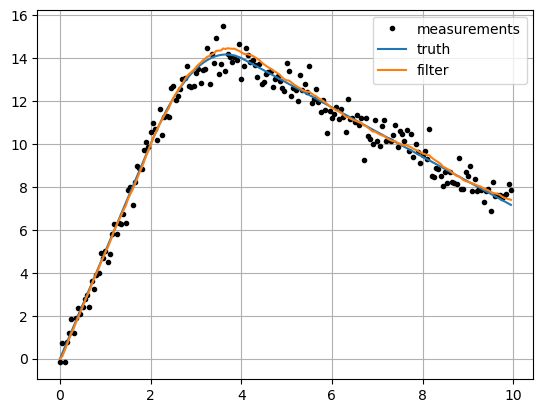

In [19]:
ind_vz = IX
fig, ax = plt.subplots()
ax.plot(time_vec, meas[ind_vz, :], 'k.', label='measurements')
ax.plot(time_vec, sim_state[ind_vz, :], '-', label='truth')
ax.plot(time_vec, kf_state[ind_vz, :], '-', label='filter')
ax.legend()
ax.grid()

In [20]:
# testing DWNA
# var_ax, var_ay, T = 1, 1, 1
# q = np.diag([var_ax, var_ay])
# gamma = np.array([
#     [0.5*T**2, 0],
#     [0,        0.5*T**2],
#     [T,        0],
#     [0,        T],
#     [1,        0],
#     [0,        1],
# ])
# Q = gamma@q@gamma.T
# Q